# Quanvolutional Neural Nets

The original writeup can be found here: https://pennylane.ai/qml/demos/tutorial_quanvolution/

The "Quanvolutional Neural Network" was originally introduced by Henderson et al. in 2019.

## Intro

### Classical Convolution

The concept of a convolutional neural network (CNN) is to have a convultional layer locally instead of processing all of the input data globally. CNNs are well-suited for processing images by using the same kernel to sequentially process small, local regions. The results of which are typically associated with different channels of a single output pixel. The resulting pixels are then unioned into a new object reminiscent of an image, which can then be processed by additional layers.

### Quantum Convolution

## Setup

In [ ]:
!pip install pennylane
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.2 MB/s eta 0:00:00


For this exercise, we'll need to import Pennylane, TensorFlow, and matplotlib.

In [ ]:
# PennyLane import
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

# TensorFlow import
import tensorflow as tf
from tensorflow import keras

# Matplotlib import
import matplotlib.pyplot as plt

### Hyper-Parameter Setup

In [ ]:
n_epochs = 30   # Number of epochs over which to optimize
n_layers = 1    # Number of random layers
n_train = 50    # Size of the training dataset
n_test = 30     # Size of the test dataset



SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

### Loading the Dataset

Since we'll be using the MNIST handwriting dataset, we can import that from Keras (in TensorFlow). For the sake of time, we'll be using only part of the dataset for this demonstration instead of training the neural network over the entire dataset. Note: This speedup in time can come at the expense of the accuracy of the model.

In [ ]:
# Importing the dataset from keras
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reducing the dataset size to n_train data points (we set it to 50 above)
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]

# Reducing the dataset size to n_test data points (we set it to 30 above)
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalizing pixel values within 0 and 1 since they're given as values gradient values of 0 to 255
train_images = train_images / 255
test_images = test_images / 255

# Adding an extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Using a Quantum Circuit as a Convolutional Kernel

Our quantum circuit consists of
1. an embedding layer of local Ry rotations (angles scaled by a factor of pi)
2. a random circuit of n_layers
3. a final measurement in the computational basis, estinating 4 expectation values

All of this setup is performed on Pennylane's "default.qubit" simulator, established by the qnode set in the following code block.

In [ ]:
# Setting our quantum device (in this case, a Pennylane simulator)
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

# Establishing a qnode for our device
@qml.qnode(dev)

# Defining our circuit function
def circuit(phi):
    """Set up the random quantum circuit, including application of an RY gate to encode our data.

    Args:
        phi (float): Value by which we want to multiply pi to perform a rotation
          about the y-axis.

    Returns:
        tensor: The expectation value of PauliZ.
    """

    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

This next part defines our convolution:
1. The image is broken down in 2x2-pixel squares
2. Each of these 2x2 squares is then processed.
3. The resulting 4 expectation values are subsequently mapped into 4 different channels of a single pixel for the output.

This reduces the resolution of the input image by half, corresponding to a stride of 2 with a 2x2 kernel convolution.

In [ ]:
# Defining our quanv function
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""

    # Setting an array of zeros that we can fill in later with actual data
    out = np.zeros((14, 14, 4))

    # Looping over coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Processing a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],                 # top left
                    image[j, k + 1, 0],             # top right
                    image[j + 1, k, 0],             # bottom left
                    image[j + 1, k + 1, 0]          # bottom right
                ]
            )
            # Assigning expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Pre-Processing the Data (Images)

It is more efficient to use the quantum layer as a pre-processing layer for the image data instead of training that convolutional layer, so that's exactly what we'll do next. It's the classical layer(s) which will be trained and tested to avoid unnecessary repetitions of quantum computations (on our simulator or on a real device should we choose to use it).

Note: Since we are preprocessing the images below and saving them in another folder, by changing "PREPROCESS == TRUE" to "PREPROCESS == FALSE" in our hyperparameter setup, we can avoid preprocessing the data each subsequent time the code is run.

In [ ]:
# Only pre-process if "PREPROCESS" is set to "True", which we did in our hyper-parameter setup code block
if PREPROCESS == True:
    # Creating an empty list to which we'll append our training data
    q_train_images = []
    print("Quantum pre-processing of train images:")
    # Enumerating over index and image in the training data
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        # Appending convoluted image data to list
        q_train_images.append(quanv(img))
    # Converting our list to a numpy array
    q_train_images = np.asarray(q_train_images)

    # Creating an empty list to which we'll append our test data
    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    # Enumerating over index and image in the test data
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        # Appending convoluted image data to list
        q_test_images.append(quanv(img))
    # Converting our list to a numpy array
    q_test_images = np.asarray(q_test_images)

    # Saving pre-processed images for both training and test datasets
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Loading pre-processed images from the directory in which we saved them
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


### Visualizing the Effects of the Convolution (Input vs. Each Output Channel)

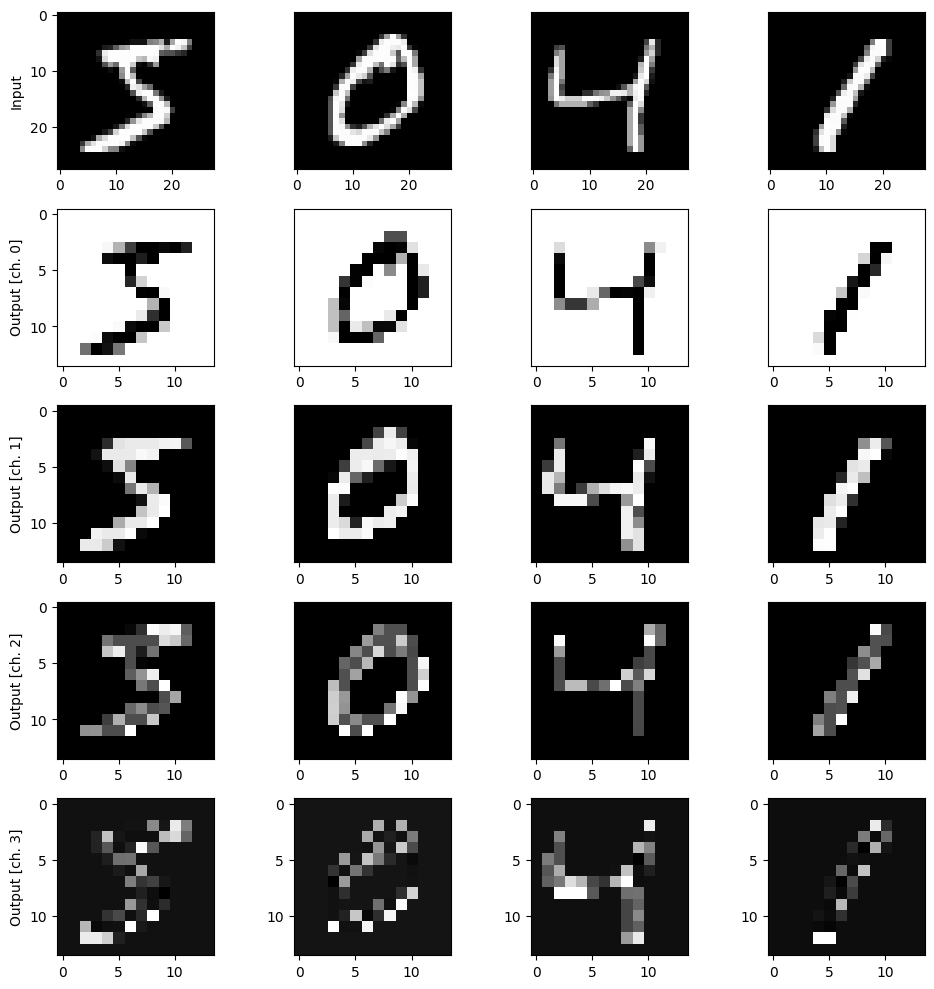

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Hybrid Quantum-Classical Model

After the quantum convolutional layer, the resulting features are fed into the next layer, a classical neural network, that will be trained to classify the 10 digits in the dataset.

This classical model is composed of a single layer with 10 output nodes and a softmax activation function. It is compiled with a stochastic-gradient-descent optimizer and a cross-entropy loss function.

In [ ]:
# Defining the classical part of the model
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    # Initializing the sequential model
    model = keras.models.Sequential([ ##################
        keras.layers.Flatten(), ##################
        keras.layers.Dense(10, activation="softmax") ##################
    ])

    # Compiling the model
    model.compile(
        optimizer='adam', ##################
        loss="sparse_categorical_crossentropy", ##################
        metrics=["accuracy"], ##################
    )
    return model

### Training

We instantiate our model that we will use on the data that has been pre-processed by our quantum layer.

In [ ]:
# Establishing our quantum model
q_model = MyModel()

# Fitting the model on the quantum training images + labels, referencing test data for validation, and using hyper-parameter specifications
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 85ms/step - accuracy: 0.1000 - loss: 2.7170 - val_accuracy: 0.1667 - val_loss: 2.3048
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.3000 - loss: 1.9869 - val_accuracy: 0.2000 - val_loss: 2.1188
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.5600 - loss: 1.6577 - val_accuracy: 0.2667 - val_loss: 1.9669
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.7000 - loss: 1.3414 - val_accuracy: 0.3000 - val_loss: 1.8031
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8600 - loss: 1.1026 - val_accuracy: 0.4333 - val_loss: 1.6997
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.9089 - val_accuracy: 0.5000 - val_loss: 1.6095
Epoch 7/30
13/13 - 0s - 7ms/step - accuracy: 0.9800 - loss: 0.7546 - val_accuracy: 0.5333 - val_loss: 1.5303
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.6348 - val_accuracy: 0.5667 - val_loss: 1.4683
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 1.0000 - loss: 0.5389 - val_accuracy: 0.6000 - val_loss: 1.4158
Epoch 10/30
13/1

Next, we will instantiate our purely classical model with our initial image data (not the data that has been pre-processed by a quantum later as above).

In [ ]:
# Establishing our classical model
c_model = MyModel()

# Similar to the quantum model but using original "train_images" and "test_images" as opposed to "q_train_images" or "q_test_images" as the quantum did
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 68ms/step - accuracy: 0.1000 - loss: 2.2782 - val_accuracy: 0.2000 - val_loss: 2.1962
Epoch 2/30
13/13 - 0s - 11ms/step - accuracy: 0.4800 - loss: 1.8730 - val_accuracy: 0.3000 - val_loss: 2.0651
Epoch 3/30
13/13 - 0s - 10ms/step - accuracy: 0.7000 - loss: 1.5906 - val_accuracy: 0.3000 - val_loss: 1.9402
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.8000 - loss: 1.3599 - val_accuracy: 0.3333 - val_loss: 1.8213
Epoch 5/30
13/13 - 0s - 9ms/step - accuracy: 0.8600 - loss: 1.1694 - val_accuracy: 0.4000 - val_loss: 1.7152
Epoch 6/30
13/13 - 0s - 8ms/step - accuracy: 0.9200 - loss: 1.0123 - val_accuracy: 0.4333 - val_loss: 1.6250
Epoch 7/30
13/13 - 0s - 11ms/step - accuracy: 0.9600 - loss: 0.8824 - val_accuracy: 0.5000 - val_loss: 1.5493
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.7744 - val_accuracy: 0.5667 - val_loss: 1.4857
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.6839 - val_accuracy: 0.6333 - val_loss: 1.4318
Epoch 10/30
13

## Results

We now want to visualize how the accuracy and loss changed with each epoch, so we will use MatPlotLib's PyPlot to visualize these changes.

<ipython-input-16-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


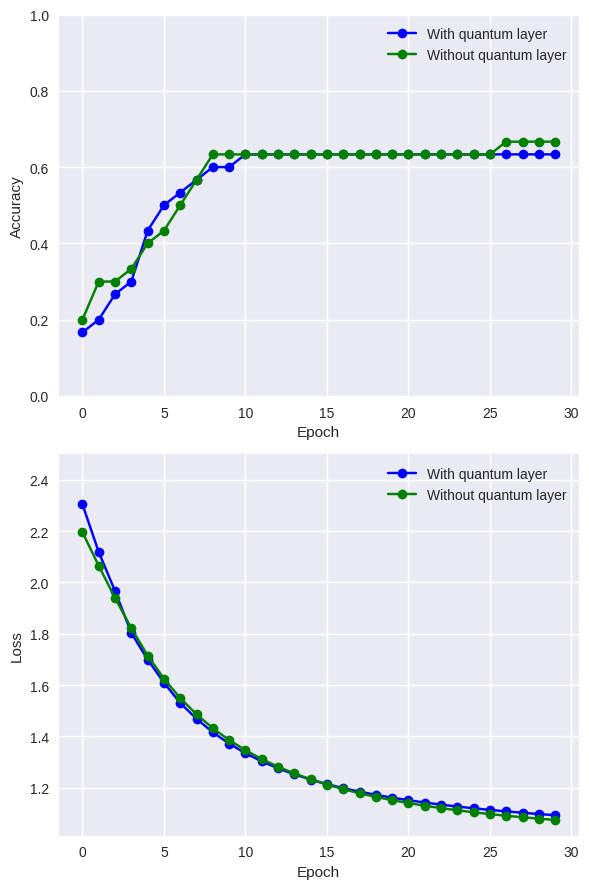

In [ ]:
# Using seaborn style of pyplot
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# Plotting the accuracy across the epochs to visualize the change
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# Plotting the loss across the epochs to visualize the change
ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()